In [2]:
import numpy as np
import torch

# load trajs_normalized_3.pt file and convert it to numpy array
trajs = torch.load('0_1_2_3/trajs_normalized_3.pt')
feats = torch.load('0_1_2_3/feats_mn.pt')

t_steps = trajs.shape[1]
num_val = 8
num_demos = feats.shape[0] - num_val
num_modes = 4
dy = 3
dims = 1280

num_indiv, num_val_indiv = num_demos // num_modes, num_val // num_modes

movement_features = np.zeros((num_demos, t_steps, dy))
image_features = np.zeros((num_demos, dims))

v_movement_features = np.zeros((num_val, t_steps, dy))
v_image_features = np.zeros((num_val, dims))

# for each mode, select random trajs and feats to fill in the movement_features and image_features
for i in range(num_modes):
    trajs_i = trajs[i*num_indiv:(i+1)*num_indiv]
    feats_i = feats[i*num_indiv:(i+1)*num_indiv]

    v_trajs_i = trajs[num_demos + i*num_val_indiv:num_demos + (i+1)*num_val_indiv]
    v_feats_i = feats[num_demos + i*num_val_indiv:num_demos + (i+1)*num_val_indiv]

    movement_features[i*num_indiv:(i+1)*num_indiv] = trajs_i.numpy()
    image_features[i*num_indiv:(i+1)*num_indiv] = feats_i.numpy()

    v_movement_features[i*num_val_indiv:(i+1)*num_val_indiv] = v_trajs_i.numpy()
    v_image_features[i*num_val_indiv:(i+1)*num_val_indiv] = v_feats_i.numpy()

print(movement_features.shape, image_features.shape)

(32, 400, 3) (32, 1280)


In [3]:
from gmr import GMM
from movement_primitives.promp import ProMP
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_dims = movement_features.shape[2]
n_weights_per_dim = 30
promp = ProMP(n_dims=n_dims, n_weights_per_dim=n_weights_per_dim)

# Prepare training data
timesteps = np.linspace(0, 1, t_steps)
# Repeat timesteps for each demonstration
timesteps = np.tile(timesteps, (num_demos, 1))
weights = np.empty((num_demos, n_dims * n_weights_per_dim))

# Fit the ProMP model with all demonstrations
# demonstrations = [(timesteps, movement_features[demo_idx]) for demo_idx in range(num_demos)]
promp.imitate(timesteps, movement_features)

for demo_idx in range(num_demos):
    weights[demo_idx] = promp.weights(timesteps[demo_idx], movement_features[demo_idx]).flatten()

# Combine image features and ProMP weights for GMM training
image_features_flat = np.tile(image_features[:, np.newaxis, :], (1, 400, 1)).reshape(num_demos, -1)  # Shape (32, 1280*400)

scaler = StandardScaler()
image_features_normalized = scaler.fit_transform(image_features_flat)

pca = PCA(n_components=32)  # Adjust the number of components as needed (must be <= 32)
image_features_reduced = pca.fit_transform(image_features_normalized)

# Combine reduced image features and ProMP weights for GMM training
X = np.hstack((image_features_reduced, weights))  # Shape (32, 20 + n_dims * n_weights_per_dim)

gmm = GMM(n_components=8, random_state=1234)
gmm.from_samples(X)

def get_promp_from_image_features(image_features):
    image_features_flat = image_features.reshape(1, -1)  # Shape (1, 1280*400)
    image_features_normalized = scaler.transform(image_features_flat)
    image_features_reduced = pca.transform(image_features_normalized)
    
    context = image_features_reduced[0]
    
    # Condition GMM on the reduced image features
    conditional_weight_distribution = gmm.condition(np.arange(len(context)), context).to_mvn()
    conditional_mean = conditional_weight_distribution.mean[-n_dims * n_weights_per_dim:]
    conditional_covariance = conditional_weight_distribution.covariance[-n_dims * n_weights_per_dim:, -n_dims * n_weights_per_dim:]
    promp.from_weight_distribution(conditional_mean, conditional_covariance)


0


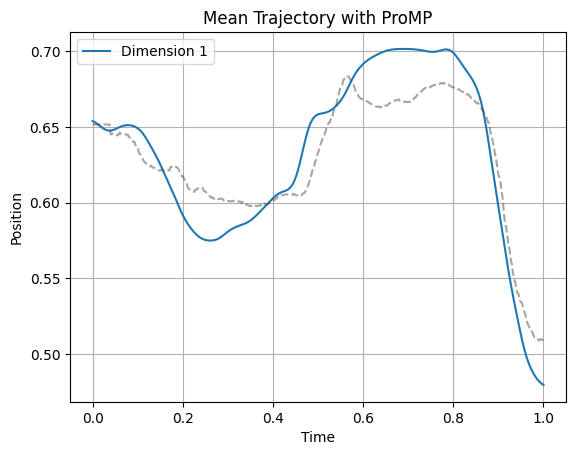

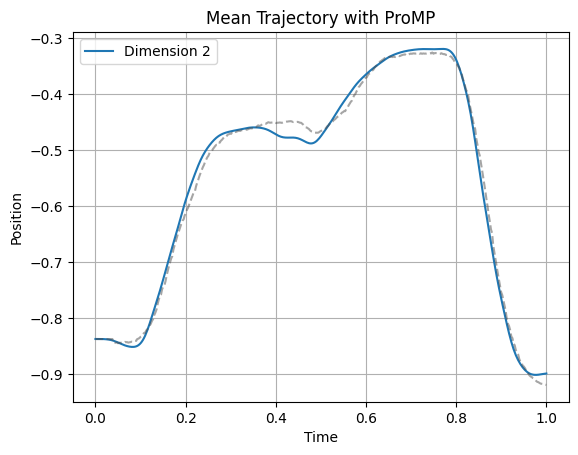

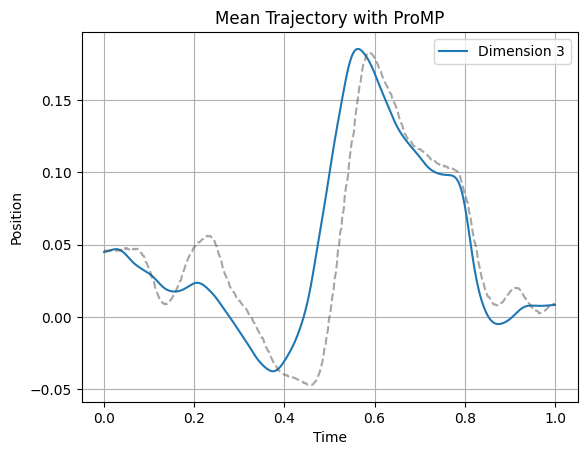

In [8]:
val_id = np.random.randint(0, num_val)
print(val_id)

new_image_features = np.tile(v_image_features[val_id], (t_steps, 1))

get_promp_from_image_features(new_image_features)

val_ts = timesteps[0]
mean_trajectory = promp.mean_trajectory(val_ts)
cov_trajectory = promp.cov_trajectory(val_ts).reshape(mean_trajectory.shape[0], mean_trajectory.shape[1], mean_trajectory.shape[1], mean_trajectory.shape[0])

minmax_path = '0_1_2_3'
if dy == 3:
    minmax_path += '/minmax3.pt'
else:
    minmax_path += '/minmax8.pt'

minmax = torch.load(minmax_path)

val_traj = np.zeros_like(v_movement_features[val_id])

# denormalize mean_trajectory and demonstration in each dimension using corresponding minmax
for i in range(dy):
    mean_trajectory[:, i] = 0.5 * (mean_trajectory[:, i] + 1) * (minmax[i][1] - minmax[i][0]).numpy() + minmax[i][0].numpy()
    val_traj[:, i] = 0.5 * (v_movement_features[val_id, :, i] + 1) * (minmax[i][1] - minmax[i][0]).numpy() + minmax[i][0].numpy()

for i in range(n_dims):
    plt.plot(val_ts, mean_trajectory[:, i], label=f'Dimension {i+1}')
    plt.plot(val_ts, val_traj[:, i], color='#4d4d4d', linestyle='--', alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Mean Trajectory with ProMP')
    plt.grid()
    plt.legend()
    plt.show()